# Exploratory Analysis

## Data Collection

Since this is our first try, I'm going to avoid getting into anything too fancy.

The price data I'll be using is collected from Binance, one of the largest cryptocurrency exchanges out there.

For this introduction, we'll be working with daily btc-usdt candlesticks. We could use more granular timeseries data or alternative bars (such as volume bars or running bars), but I'm just going to keep things simple for now.

My hope is to make improvements as we move along. An incremental approach.

Feel free to check out the [trader](https://github.com/MichaelDragan/trader) library used in this notebook. :)


In [1]:
import pandas as pd
import numpy as np
from trader import Binance

# I like to define these first, just so I don't have to later on
COLOURS = {
    "general": ["#3C8280", "#FAB131", "#ED5A3F"],
    "greens": ["#3C8280", "#7CB7B6", "#E5F1F0"],
    "reds": ["#ED5A3F", "#F27C5E", "#FBDED9"],
    "yellows": ["#FAB131", "#FBBC50", "#FDD898"]
}

# "Mining" Bitcoin
binance = Binance()
# List of BaseBar objects. We'll explore these in more depth in the near future
btc_usdt = binance.get_historical("BTCUSDT", interval="1d") 

# We'll just package our data up in the form of a dataframe
dataset = pd.DataFrame(data=[btc.to_dict() for btc in btc_usdt]).set_index("timestamp")
dataset


,open,high,low,close,volume,n_trades
timestamp,,,,,,
2017-08-17 23:59:59,4261.48,4485.39,4200.74,4285.08,795.150377,3427
2017-08-18 23:59:59,4285.08,4371.52,3938.77,4108.37,1199.888264,5233
2017-08-19 23:59:59,4108.37,4184.69,3850.00,4139.98,381.309763,2153
2017-08-20 23:59:59,4120.98,4211.08,4032.62,4086.29,467.083022,2321
2017-08-21 23:59:59,4069.13,4119.62,3911.79,4016.00,691.743060,3972
...,...,...,...,...,...,...
2021-06-05 23:59:59,36829.15,37925.00,34800.00,35513.20,70459.621490,1463754
2021-06-06 23:59:59,35516.07,36480.00,35222.00,35796.31,47650.206637,993430
2021-06-07 23:59:59,35796.31,36900.00,33300.00,33552.79,77574.952573,1532260


# A Quick Look

Let's visualize the growth of Bitcoin!

In the next notebook, we'll be analyzing the statistical properties of our price data. While we're not going to look at how normally distributed our returns are, it's imparative we do in the future.

Stay tuned!

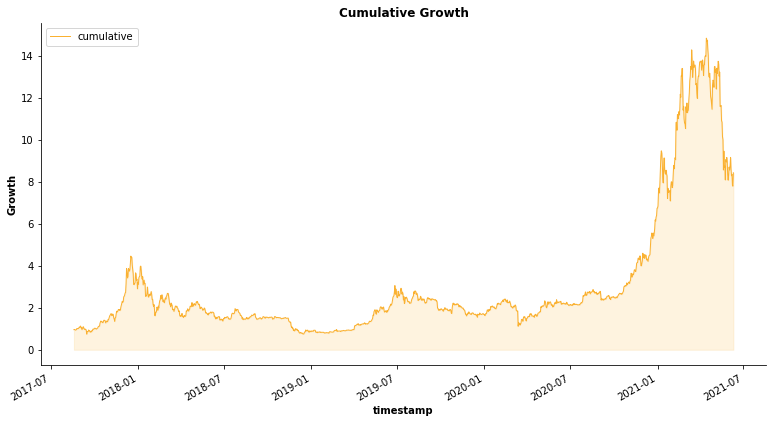

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating Growth
dataset["returns"] = dataset["close"].pct_change() 
dataset["cumulative"] = dataset["returns"].add(1).cumprod()

# Visualizing Growth Growth
fig, ax = plt.subplots(figsize=(13, 7))

# Modify the plot
ax.set_title("Cumulative Growth", fontweight="bold")
ax.set_ylabel("Growth", fontweight="bold")
ax.set_xlabel("Date", fontweight="bold")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Plotting the cumulative returns
dataset[["cumulative"]].plot(ax=ax, color="#FAB131", linewidth=1)
ax.fill_between(dataset.index, dataset.cumulative, alpha=0.3, color="#FDD898")
ax

# So when should I hold or sell my Bitcoin?

I want to hold Bitcoin when its value is trending upwards, and sell when its trending downwards. For that we'll need to label our data.

I'm going to take the rate of change of Bitcoin's moving price average in order to label our dataset.

In a future notebook, we'll try labelling using the tripple barrier labelling method discussed by Marcos López de Prado.

## Methodology:
- I'm going to take a moving average (exponentially weighted) to identify trends within the market.

- Take the rate of change of the moving average. If the change is above 0, then label 1(buy), else label 0 (hold).

- Moving averages (depending on what lookback window you're using) tend to hug significant price movements closely, and also smooth out less volatile periods.

- I also want to ensure I'm not trading too frequently because slippage is much more of an issue on cryptocurrency exchanges.

## Some Observations:
- Based on the plot below, I would be rather happy if I held on the greens and sold on the reds. Not the best (especially when you zoom out), but pretty decent!

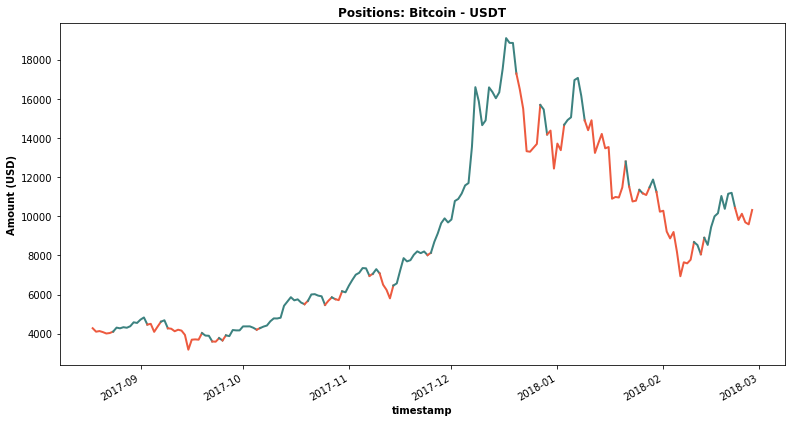

In [4]:
# Lookback windows I'll use to make some calculations here and on the next cell.
SHORT = 5
WINDOW = 30

def partition(series: pd.Series) -> iter:
    """ Generator Function

    Every iteration is a pandas series of consecutive positions.

    For example, [0,0,0,1,1,1] would return [0, 0, 0], [1, 1, 1].

    ARGS:
    series (pd.Series): Market positions.
    """
    curr = 0
    start = 0
    for i, value in enumerate(series, 1):
        if value != curr:
            yield series[start:i]
            curr, start = value, i - 1

# Calculating the moving average.
dataset["ema"] = dataset["close"].ewm(span=SHORT).mean()
# Adding the labels to the dataset (we'll be trying to predict these).
# To do this, I'm going to take rate of change of the moving average. If the rate of change is above 0 (trending up) -> label = 1 (hold) ... otherwise label = 0 (sell)
dataset["label"] = dataset["ema"].pct_change().fillna(0).apply(lambda x: 1 if x > 0 else 0)
sample = dataset.head(200) # The dataset as a whole is too large to visualize nicely. With a smaller sample we can have a better idea of what's g

# Plotting out the results
fig, ax = plt.subplots(figsize=(13, 7))

ax.set_title("Positions: Bitcoin - USDT", fontweight="bold")
ax.set_ylabel("Amount (USD)", fontweight="bold")
ax.set_xlabel("Date", fontweight="bold")

for series in partition(sample["label"]):
    color = COLOURS["reds"][0] if series[0] == 0 else COLOURS["greens"][0]
    sample["close"].loc[series.index].plot(ax=ax, color=color, linewidth=2)

ax

# Feature Engineering and Messy Visualizations

Feature engineering is just a fancy way of saying "let's describe our data".

I'm no expert, but I do know some common indicators that traders use to make financial decisions. I've included a description just below.

When you draw out these features, they look rather messy. I know I wouldn't be able to look at these charts and make any informed decision. It's way too confusing! I'd rather leverage some decision making machine learning algorithm to help me out.

That, and I just think it's good practice to actually visualize your features. Some interesting findings may emerge!

## The Features

When I think of market indicators, these 5 categories come to mind.

1. Risk: "How much could I lose?"
2. Momentum: "How fast is the market moving?"
3. Volatility: "How stable is the market?"
4. Risk Adjusted Returns: "Is it worth it?"
5. Volume: "How much is being traded?"

For now I'm just using some of the indicators I understand best.


In [5]:
import empyrical as emp
from ta import momentum, volume, volatility, trend, others

# I'm just putting these here for plotting purposes.
groups = {
    "Risk Adjusted Returns": ["omega", "sortino", "sharpe"],
    "Risk Indicators": ["var", "downside"],
    "Volatility": ["atr"],
    "Volume": ["vwap"],
    "Momentum": ["rsi"],
    "Trend": ["macd"],
}

# Risk Adjusted Returns
dataset["omega"] = dataset["returns"].rolling(WINDOW).apply(emp.omega_ratio)
dataset["sortino"] = dataset["returns"].rolling(WINDOW).apply(emp.sortino_ratio)
dataset["sharpe"] = dataset["returns"].rolling(WINDOW).apply(emp.sharpe_ratio)

# Risk
dataset["var"] = dataset["returns"].rolling(WINDOW).apply(emp.value_at_risk)
dataset["downside"] = dataset["returns"].rolling(WINDOW).apply(emp.downside_risk)

# Momentum
dataset["rsi"] = momentum.rsi(dataset["close"])

# Volatility
dataset["atr"] = volatility.average_true_range(dataset["high"], dataset["low"], dataset["close"])

# Volume Indicators
dataset["vwap"] = volume.volume_weighted_average_price(
    dataset["high"], dataset["low"], dataset["close"], dataset["volume"]
)

# Trend
dataset["macd"] = trend.macd(dataset["close"])

# And now we'll justclean things up
dataset.dropna(inplace=True)


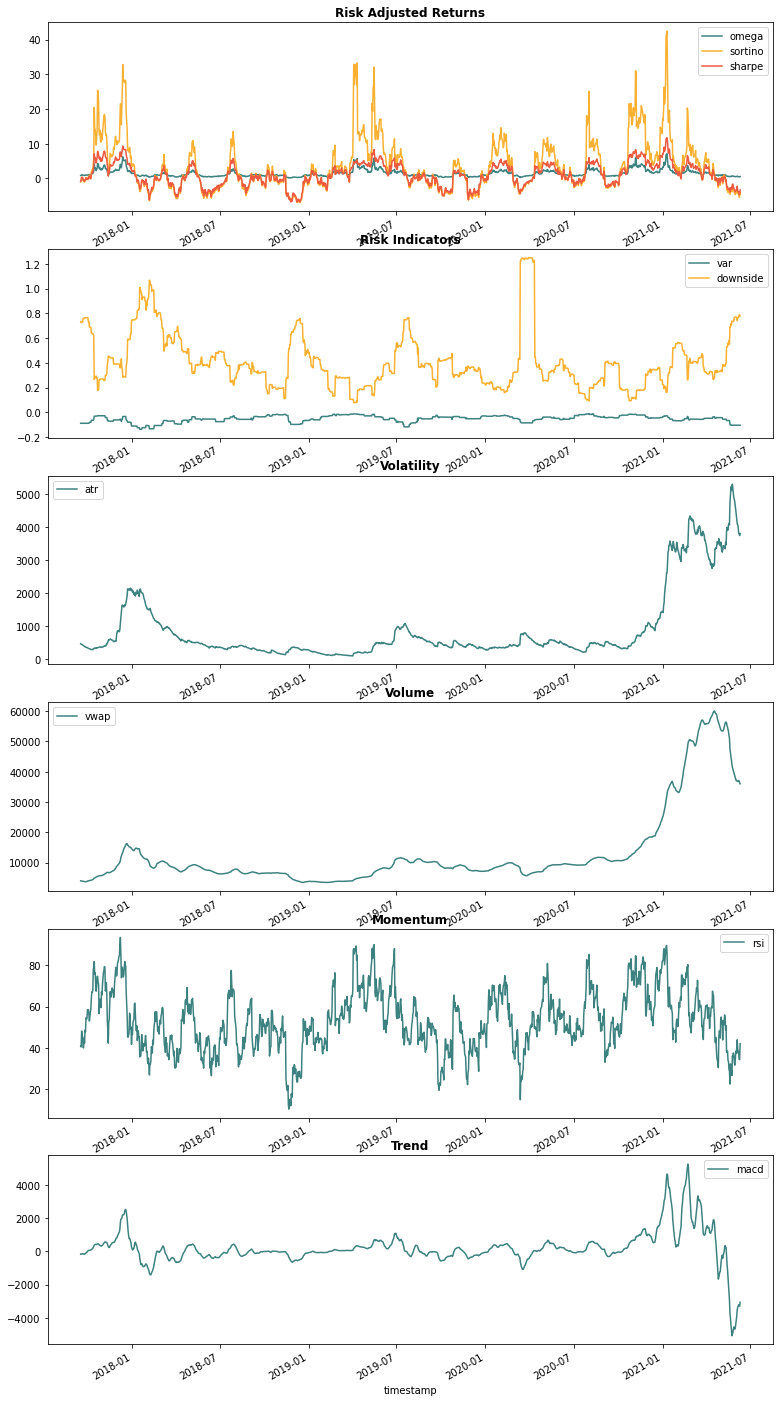

In [6]:
# Visualizing the price derivatives / features.
fig, axes = plt.subplots(len(groups), figsize=(13, 27))

for i, key in enumerate(groups):
    columns = groups[key]
    colour = COLOURS["general"][:len(columns)]
    
    axes[i].set_title(key, fontweight="bold")
    dataset[columns].plot(color=colour, ax=axes[i])

# Checking out our technical indicators (feature analysis)

In general, we want to feed our models uncorrelated features. That's because significantly correlated features tend tell the same story. Too many features that tell the same story contribute to noise. Simple is better.

There are ways we can reduce this kind of overlap. For example we can utilize principle component analysis (PCA) or even some clustering methods to group together similar features.

We'll skip that for now and just take a look.

Looking at the correlation matrix, we find that there's strong correlations within groups (risk: sharpe, sortino, and sharpe overlap a ton), but there are some uncorrelated features (VWAP).

We'll take note of this for future iterations.

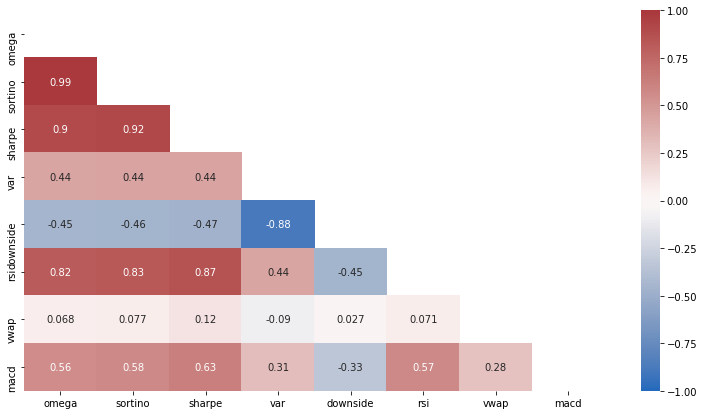

In [7]:
indicator_columns = [
    "omega",
    "sortino",
    "sharpe",
    "var",
    "downside",
    "rsi",
    "vwap",
    "macd",
]
indicators = dataset[indicator_columns]
correlations = indicators.corr()

plt.figure(figsize=(13, 7))
mask = np.triu(np.ones_like(correlations, dtype=np.bool))
heatmap = sns.heatmap(correlations, mask=mask, vmin=-1, vmax=1, annot=True, cmap="vlag")
heatmap



# Feature Importance

I'm just going to use a random forest classifier to see if the model is biased towards one feature.

We can see that it favours the relative strength index (rsi), but also has the tendency to select the other features equally.

I'm okay with this for now.

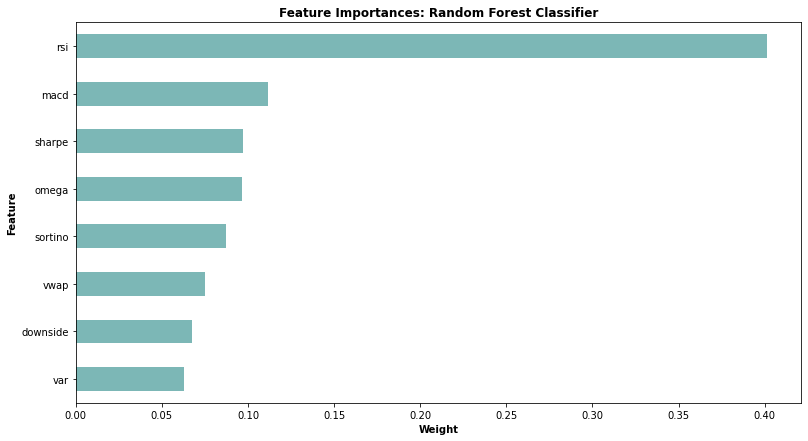

In [8]:
from sklearn import ensemble, feature_selection

# Create and train a random forest classifier
rf = ensemble.RandomForestClassifier()
rf.fit(dataset[indicator_columns], dataset["label"])

# Create a series to store the rf's feature importances.
importances = pd.Series(rf.feature_importances_, index=indicator_columns)

# Plot >>
fig, ax = plt.subplots(figsize=(13, 7))

ax.set_title("Feature Importances: Random Forest Classifier", fontweight="bold")
ax.set_ylabel("Feature", fontweight="bold")
ax.set_xlabel("Weight", fontweight="bold")

importances.sort_values().plot(kind="barh", color="#7CB7B6", ax=ax)


# Cross Validation - Timeseries Splits

Given we are satisfied with how we labelled our data (which is pretty much going to be our trading strategy), let's see how well a random forest classifier can perform.

When working with price data, we need to remember that we are working with timeseries data. It's imparative that we don't shuffle our data!

This is why the TimeSeriesSplit from Sklearn is suited for seeing how well a model can perform for our given dataset.

In short, we are going to partition our dataset into n splits, train a random forest classifier on each split, and record how well it did each time.

I'm not going to do anything fancy with the model. We can save hyperparameter tuning for another notebook!


In [9]:
from sklearn import model_selection, metrics
from collections import OrderedDict
from pprint import pprint

# Splits
time_folds = model_selection.TimeSeriesSplit(n_splits=10)

reports = []
# for each iteration, train a random forest and append the results to the above reports.
for train_i, test_i in time_folds.split(dataset[indicator_columns], dataset["label"]):
    report = OrderedDict()

    x_train, y_train = dataset[indicator_columns].iloc[train_i], dataset["label"][train_i]
    x_test, y_test = dataset[indicator_columns].iloc[test_i], dataset["label"][test_i]

    model = ensemble.RandomForestClassifier(n_estimators=1000)

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    report["Test Start Date"] = y_test.index[0]
    report["Train Size"] = len(y_train)
    report["Test Size"] = len(y_test)
    report["Accuracy"] = metrics.accuracy_score(y_test, y_pred)
    report["F1"] = metrics.f1_score(y_test, y_pred)
    report["Recall"] = metrics.recall_score(y_test, y_pred)
    report["Precision"] = metrics.precision_score(y_test, y_pred)
    report["Count: Hold"] = y_test[y_test == 1].count()
    report["Count: Exit"] = y_test[y_test == 0].count()
    report["Hold Ratio"] = report["Count: Hold"] / len(y_test)

    reports.append(report)

evaluation = pd.DataFrame(reports)
evaluation


,Test Start Date,Train Size,Test Size,Accuracy,F1,Recall,Precision,Count: Hold,Count: Exit,Hold Ratio
0,2018-01-18 23:59:59,124,124,0.750000,0.673684,0.571429,0.820513,56,68,0.451613
1,2018-05-22 23:59:59,248,124,0.814516,0.796460,0.703125,0.918367,64,60,0.516129
2,2018-09-22 23:59:59,372,124,0.685484,0.672269,0.869565,0.547945,46,78,0.370968
3,2019-01-24 23:59:59,496,124,0.717742,0.810811,0.937500,0.714286,80,44,0.645161
4,2019-05-28 23:59:59,620,124,0.790323,0.786885,0.827586,0.750000,58,66,0.467742
5,2019-09-29 23:59:59,744,124,0.854839,0.850000,0.850000,0.850000,60,64,0.483871
6,2020-01-31 23:59:59,868,124,0.895161,0.909091,0.928571,0.890411,70,54,0.564516
7,2020-06-03 23:59:59,992,124,0.806452,0.803279,0.765625,0.844828,64,60,0.516129
8,2020-10-05 23:59:59,1116,124,0.870968,0.913978,0.894737,0.934066,95,29,0.766129
9,2021-02-06 23:59:59,1240,124,0.806452,0.818182,0.771429,0.870968,70,54,0.564516


# Results

I'm pretty pleased with the results of the cross validation. Some splits do better than others, but the data suggests that we are performing better than chance.

To finish off let's just visualize the predictions!

I think our findings are dope! I'd consider this a victory, there's only room for imporovement!

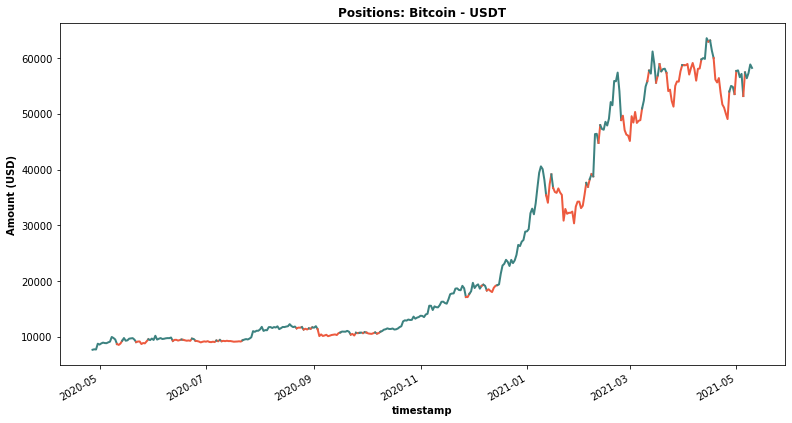

In [10]:
train, test = model_selection.train_test_split(dataset, test_size=0.3, shuffle=False)

rf = ensemble.RandomForestClassifier(n_estimators=1000)
rf.fit(train[indicator_columns], train["label"])

y_pred = pd.Series(rf.predict(test[indicator_columns]), index=test.index)


# Plotting out the results
fig, ax = plt.subplots(figsize=(13, 7))

ax.set_title("Positions: Bitcoin - USDT", fontweight="bold")
ax.set_ylabel("Amount (USD)", fontweight="bold")
ax.set_xlabel("Date", fontweight="bold")

for series in partition(y_pred):
    color = "#ED5A3F" if series[0] == 0 else "#3C8280"
    test["close"].loc[series.index].plot(ax=ax, color=color, linewidth=2)

ax
